<a href="https://colab.research.google.com/github/dutrajunior/python_estudos/blob/main/Tratamento_de_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns

!pip install Faker
from faker import Faker

In [2]:
#Cria e popula dataframe para testes

#criar lista com 100 nomes
fake = Faker()
Faker.seed(4321)
lista_nomes = []
fake = Faker()
for _ in range(100):
  lista_nomes.append(fake.name())


#criar lista com 100 salarios
np.random.seed(7)
salarios = []

for _ in range(100):
  salario = np.random.randint(1000,2500)
  salarios.append(salario)

#Juntar listas de nomes em salarios em um dataframe
salario_df = pd.DataFrame.from_dict({'Pessoa': lista_nomes, 'Salario': salarios})

print(salario_df.head())

              Pessoa  Salario
0        Jason Brown     1175
1        Jacob Stein     2220
2         Cody Brown     1537
3      Larry Morales     1502
4  Jessica Hendricks     1211


In [3]:
#Força outliers para testes

salario_df.at[16,'Salario']=23
salario_df.at[65,'Salario']=17

In [4]:
#exibe o dataframe
salario_df

,Pessoa,Salario
0,Jason Brown,1175
1,Jacob Stein,2220
2,Cody Brown,1537
3,Larry Morales,1502
4,Jessica Hendricks,1211
...,...,...
95,Robert Garrett,1260
96,Parker Kent,1456
97,Michelle Logan,2498
98,Beverly Baker DVM,2007


In [5]:
#exibe os tipos de dados do dataframe
salario_df.dtypes

Pessoa     object
Salario     int64
dtype: object

In [6]:
# Identifica colunas numéricas e não numéricas
col_objetos = []
col_numeric = []

for i in salario_df.dtypes.index:
    if salario_df.dtypes[i] == 'object':
        col_objetos.append(i)
    else:
        col_numeric.append(i)

print('Colunas numericas: ',col_numeric)
print('Colunas objetos: ',col_objetos)

Colunas numericas:  ['Salario']
Colunas objetos:  ['Pessoa']


In [7]:
# Descreve as medias das colunas numéricas
salario_df.describe()

,Salario
count,100.000000
mean,1741.100000
std,490.420444
min,17.000000
25%,1384.750000
50%,1768.000000
75%,2148.750000
max,2498.000000


In [8]:
# identifica registros duplicados
duplicados = salario_df[salario_df.duplicated(keep='first')]
print(duplicados)

Empty DataFrame
Columns: [Pessoa, Salario]
Index: []


In [9]:
# Remove registros duplicados
salario_df.drop_duplicates(keep='first', inplace=True)

In [10]:
# Função para alterar dados vazios por moda
def nan_to_mode(DataFrame, col_name):
  DataFrame[col_name].fillna(salario_df[DataFrame].mode()[0], inplace=True)

# Função para alterar dados vazios por mediana
def nan_to_mean(DataFrame, col_name):
  DataFrame[col_name].fillna(salario_df[DataFrame].mean()[0], inplace=True)

In [11]:
# Loop nas colunas numéricas para preencher os registros com dados vazios
for column in col_numeric:
  print(column)
  #nan_to_mode(salario_df, column)
  #nan_to_mean(salario_df, column)

Salario


In [ ]:
# Remove todos os registros que tenha dados vazios
#salario_df.dropna(inplace=True)

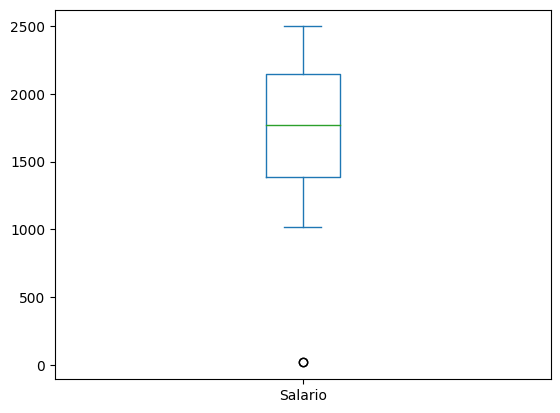

In [12]:
# Plota o gráfico para verificar os outliers
salario_df['Salario'].plot(kind='box')
plt.show()

In [14]:
# Função para exibir indice e outliers

def show_outliers(DataFrame, col_name):
  valores = DataFrame[col_name]
  factor = 1.5
  q3, q1 = np.percentile(valores, [75, 25])
  iqr = q3 - q1
  parte_baixa = q1 - (iqr * factor)
  parte_alta = q3 + (iqr * factor)
  return valores[(valores < parte_baixa) | (valores > parte_alta)]


outliers = show_outliers(salario_df, 'Salario')
outliers

16    23
65    17
Name: Salario, dtype: int64

In [17]:
#Função para retornar somente outliers
boxplot_stats(salario_df["Salario"].dropna()).pop(0)['fliers']

array([23, 17])

In [18]:
#função para retornar distancia de Mahalanobis
def dist_mahalanobis(DataFrame):
  import glob
  from sklearn.covariance import MinCovDet
  %matplotlib inline
  col_numeric = []

  for i in DataFrame.dtypes.index:
      if DataFrame.dtypes[i] != 'object':
          col_numeric.append(i)

  mcd = MinCovDet(assume_centered=True, random_state=42)
  cov = mcd.fit(DataFrame[col_numeric])
  distancias = pd.DataFrame(cov.dist_ ,index=DataFrame[col_numeric].index,columns=['Distancia Mahalanobis'])
  resultados = pd.concat([DataFrame[col_numeric],distancias],axis=1)
  return resultados.sort_values(by='Distancia Mahalanobis',ascending=False).head()

In [19]:
# Retornando a distancia de Mahalanobis
dist_mahalanobis(salario_df)

# Os valores deste resultado indicam potencialmente amostras que apresentam um alto grau de distância em relação ao resto da distribuição.
# Consequentemente, há uma grande chance de essas amostras serem marcadas como outliers.

,Salario,Distancia Mahalanobis
97,2498,1.908529
36,2486,1.890236
54,2472,1.869006
24,2468,1.862963
17,2456,1.844890


<Axes: >

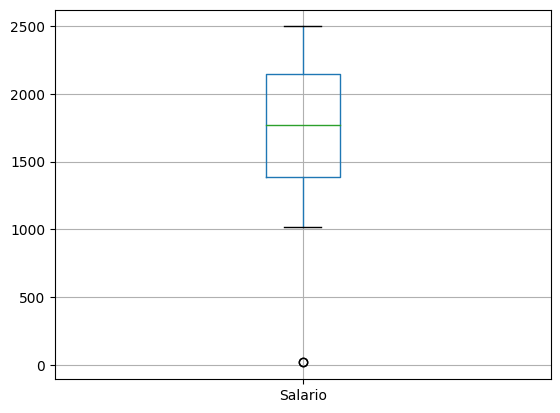

In [20]:
salario_df.boxplot()

In [21]:
# Função para remover outliers

def drop_outliers(DataFrame, col_name):
  intervalo = 2.7*DataFrame[col_name].std()
  media = DataFrame[col_name].mean()
  DataFrame.loc[salario_df[col_name] < (media - intervalo), col_name] = np.nan
  DataFrame.loc[salario_df[col_name] > (media + intervalo), col_name] = np.nan

In [22]:
# Remoção de outliers
for col in col_numeric:
  drop_outliers(salario_df, col)

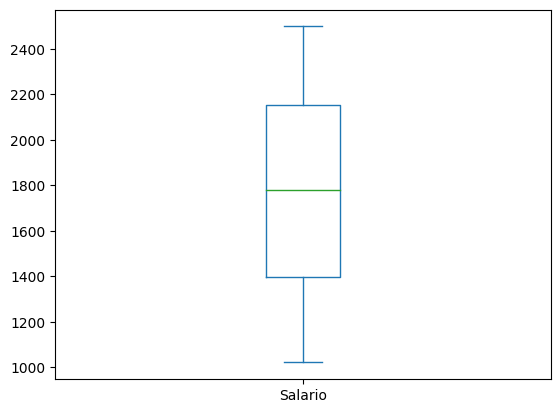

In [23]:
# Plota o gráfico para verificar os outliers

salario_df['Salario'].plot(kind='box')
plt.show()

<Axes: xlabel='Salario', ylabel='Density'>

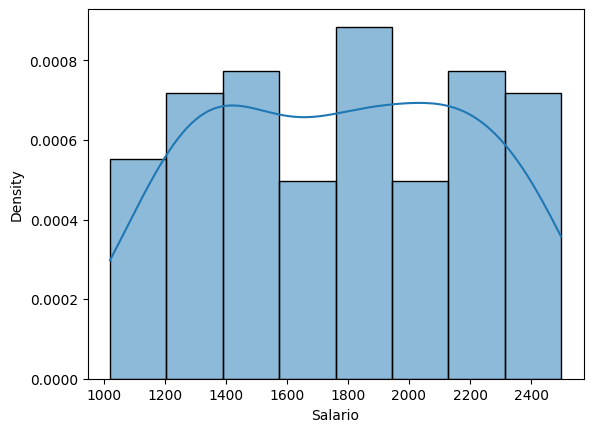

In [24]:
sns.histplot(salario_df['Salario'], kde=True, stat="density")